In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import glob
import numpy as np
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib
import matplotlib.pyplot as plt

In [0]:
def intersect_two_normal(data1, data2, title):

    def prob_value(bins, mu, sigma):
        output = 1/(sigma * np.sqrt(2 * np.pi))
        output *= np.exp( - (bins - mu)**2 / (2 * sigma**2))
        return output
    
    # mean, s.e.
    mu_s, sigma_s = np.mean(data1), np.std(data1)
    mu_pos, sigma_pos = np.mean(data2), np.std(data2)
    
    # probability of given bins value
    bins = np.arange(min(min(data1), min(data2)), 
                     max(max(data1), max(data2))+0.01, 0.1)
    value_s = prob_value(bins, mu_s, sigma_s)
    value_pos = prob_value(bins, mu_pos, sigma_pos)                                    

    # calcuate overlap
    overlap = 0
    for i, b in enumerate(bins):
        overlap+= min(value_s[i], value_pos[i])*0.1
    
    # draw plot
    plt.hist(data1, 10, density=True)
    plt.plot(bins, value_s, linewidth=2, color='r', label="data1")
    plt.hist(data2, 10, density=True)
    plt.plot(bins, value_pos, linewidth=2, color='g', label="data2")
    plt.title(title)
    plt.legend()
    plt.show()
    
    return overlap
  
  
def propensity_score(data, strata=5, treat_col='isTreat'):
    '''
        data : DataFrame, no string/object type data
               must contains [treat_col]
    '''
    model = LogisticRegression(random_state=10, solver='lbfgs',
                               multi_class='ovr')
    
    X = data[data.columns.difference([treat_col]+result_names)]
    prediction = model.fit(X, data[treat_col]).predict_proba(X)  
    model_score = model.score(X,  data[treat_col])
    print("Model score:", model_score)
    
    data.loc[:,'prediction1']=prediction[:,1]
    data.loc[:,'groups']=0
    rng = np.linspace(0, 1, strata+1) # e.g. strata is 5
    
    for i in range(len(rng)-1):
        # strata left <=prediciton1< strata right
        # group 0, 1, 2, 3, 4
        data.loc[(data['prediction1']>=rng[i])&(data['prediction1']<rng[i+1]),'groups']=i
        
    return model_score, data

def matching_groups(stratas_data, strata=False):
    
    match_by_groups = dict()
    # traverse each group, match treat and control
    for i in stratas_data.groups.unique():
        # "nrow" number of treated items
        treated = stratas_data.loc[(stratas_data.groups==i)
                                  &(stratas_data.isTreat==1),:]
        nrow = treated.shape[0]
        # match to "nrow" of control items, if no control exist then skip this strata
        controled = stratas_data.loc[(stratas_data.groups==i)&(stratas_data.isTreat==0),:]
        if controled.shape[0]==0:
            continue
        matched_control = controled.sample(n=nrow, random_state=186,replace=True)
        match_by_groups[f'group_{i}'] = pd.concat([treated, matched_control])

    match_output = pd.DataFrame(columns=stratas_data.columns)
    if not strata:  
        for g in match_by_groups:
          match_output = pd.concat([match_output, match_by_groups[g]])
        return match_output
    else:
        return match_by_groups

def find_numeric_col(df):
    non_str_col = []
    col_types = dict(df.dtypes)
    for col in col_types:
        if col_types[col]!=np.dtype('O'):
            non_str_col.append(col)
    return(non_str_col)
  

def add_dummy(df, need_factorize_cols):
    new_df = df.copy()

    drop_cols = []
    for col in need_factorize_cols:
      # if Boolean convertable
      isBoolean = len(df[col].unique())==2
     
      # print(col, isBoolean)
      if isBoolean:
        # change into 0/1
        new_df[col] = pd.factorize(new_df[col])[0]
      else:

        unique_cols = [str(cat).replace("'","").replace(" ","_").replace("-","_").replace("/","_") for cat in new_df[col].unique()]
        new_df[unique_cols[:-1]] = pd.get_dummies(new_df[col], drop_first=True)
        drop_cols.append(col)

    new_df = new_df.drop(columns=drop_cols)
    return new_df
     

In [0]:
def result_generation(df):
    ## anova test
    covariate_cols = df.columns.difference(['post_type', 'post_trust', 'condition', 'isTreat'])

    print("\n\n Share =================\n")
    summary = df.groupby(by = ['post_type', 'condition']).share_post.describe().reset_index()
    treat_mean = summary.loc[(summary.condition=="Enhanced Guidelines")&(summary.post_type=='Fake'),'mean'].values
    control_mean = summary.loc[(summary.condition=="Control")&(summary.post_type=='Fake'),'mean'].values
    mean_effect = treat_mean - control_mean
    mean_effect_share = mean_effect[0]
    print("Mean effect: ", mean_effect_share)
    print(summary)
    print("\n\n")
    formula = 'share_post ~ C(post_type) + C(condition) + C(post_type):C(condition)'
    model = ols(formula, df).fit()
    share_table = anova_lm(model, typ=1)
    # print(share_table)

    print("\n\n Trust =================\n")
    summary = df.groupby(by = ['post_type', 'condition']).post_trust.describe().reset_index()
    treat_mean = summary.loc[(summary.condition=="Enhanced Guidelines")&(summary.post_type=='Fake'),'mean'].values
    control_mean = summary.loc[(summary.condition=="Control")&(summary.post_type=='Fake'),'mean'].values
    mean_effect = treat_mean - control_mean
    mean_effect_trust = mean_effect[0]
    print("Mean effect: ", mean_effect_trust)
    print(summary)
    print("\n\n")
    formula = 'post_trust ~ C(post_type) + C(condition) + C(post_type):C(condition)'
    model = ols(formula, df).fit()
    trust_table = anova_lm(model, typ=1)
    # print(trust_table)


    ## bootstrap
    np.random.seed(0)
    data_fake = df[data_clean.post_type == 'Fake']
    bootstrap_fn = lambda x: pd.DataFrame(x.values[np.random.randint(len(x), 
                                                                     size=len(x))], 
                                          columns=x.columns)
    bootstraps = [bootstrap_fn(data_fake) for i in range(0, 1000)]
    
    ## Share =================
    mean_share_enguideline_bs = np.array([df.share_post[df.condition == 'Enhanced Guidelines'].mean() for df in bootstraps])
    mean_share_control_bs = np.array([df.share_post[df.condition == 'Control'].mean() for df in bootstraps])
    # test intersect_two_normal
    # creates normal KDE to find % overlap
    overlap = intersect_two_normal(mean_share_enguideline_bs, mean_share_control_bs, title="Share")

    # calculate # of control simulations below test estimate out of all control simulations
    test_estimate = np.quantile(mean_share_enguideline_bs, 0.5)
    p_value_s = len([i for i in mean_share_control_bs if i <= test_estimate])/len(mean_share_control_bs)
    overlap_s = round(overlap, 4)
    print("overlap is: ", overlap_s)
    print("p-value is: ", p_value_s)

    ## Trust =================
    mean_trust_enguideline_bs = np.array([df.post_trust[df.condition == 'Enhanced Guidelines'].mean() for df in bootstraps])
    mean_trust_control_bs = np.array([df.post_trust[df.condition == 'Control'].mean() for df in bootstraps])
    # test intersect_two_normal
    # creates normal KDE to find % overlap
    overlap = intersect_two_normal(mean_trust_enguideline_bs, mean_trust_control_bs, title="Trust")

    # calculate # of control simulations below test estimate out of all control simulations
    test_estimate = np.quantile(mean_trust_enguideline_bs, 0.5)
    p_value_t = len([i for i in mean_trust_control_bs if i <= test_estimate])/len(mean_trust_control_bs)
    overlap_t = round(overlap, 4)
    print("overlap is: ", overlap_t)
    print("p-value is: ", p_value_t)
    
    return mean_effect_share, mean_effect_trust, overlap_s, p_value_s, overlap_t, p_value_t

STEP 1: loading data

In [0]:
'''
Data_GEC_clean_python_friendly.csv

data_clean_missing10
'''

In [15]:
valid_data_files = glob.glob('drive/My Drive/Lutzke_2019/MNAR v2/*.csv')
missing_data_files = [f for f in valid_data_files if "missing" in f ]
missing_data_files

['drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_40.csv',
 'drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_50.csv',
 'drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_20.csv',
 'drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_10.csv',
 'drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_60.csv',
 'drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_30.csv']

Analyzing file:  drive/My Drive/Lutzke_2019/MNAR v2/data_clean_MNAR_missing_40.csv


,post_trust,post_type,condition,share_post,missing_politics,Republican,Democrat,Independent,No_party_not_interested_in_politics,Do_not_know,Incorrect,Correct,Believer,Doubter,missing_scientists_expect_warming_increase_melting,missing_scientists_expect_increase_water_evap,1.0,0.0,missing_feelings_toward_fb,0.1,4.4,_4.1,_2.9,5.0,2.9,_0.6,_1.3,2.3,_4.0,_1.0,2.4,0.5,_2.1,3.2,0.8,2.5,_0.3,1.7,_5.0,0.9,...,48.0,37.0,54.0,29.0,74.0,39.0,61.0,57.0,72.0,77.0,49.0,31.0,62.0,41.0,64.0,30.0,25.0,56.0,46.0,65.0,42.0,71.0,59.0,60.0,52.0,76.0,67.0,86.0,53.0,84.0,18.0,80.0,missing_nuclear_power_co2,missing_scientists_expect_climate_change_evenly,Male,missing_gender,Female,Prefer_not_to_say,missing_today_concentration_already_occured,isTreat
0,1.50,Fake,Enhanced Guidelines,1.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,8.05,Fake,Enhanced Guidelines,8.0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


Model score: 0.6784565916398714
                Correct
isTreat groups         
0       0            20
        1           187
        2           231
        3            34
        4             5
1       0             4
        1            65
        2           210
        3           153
        4            24


 Share =================

Mean effect:  -0.5583333333333305
  post_type            condition  count      mean  ...  25%   50%   75%   max
0      Fake              Control  456.0  4.333772  ...  1.0  3.20  6.25  11.0
1      Fake  Enhanced Guidelines  456.0  3.775439  ...  1.0  2.75  6.00  11.0

[2 rows x 10 columns]





 Trust =================

Mean effect:  -0.2669956140350891
  post_type            condition  count      mean  ...   25%    50%   75%   max
0      Fake              Control  456.0  4.296601  ...  1.55  3.925  6.55  10.0
1      Fake  Enhanced Guidelines  456.0  4.029605  ...  1.85  3.775  5.80  10.0

[2 rows x 10 columns]





/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


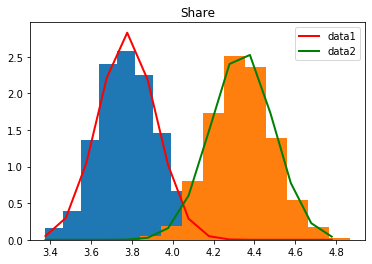

overlap is:  0.0534
p-value is:  0.0


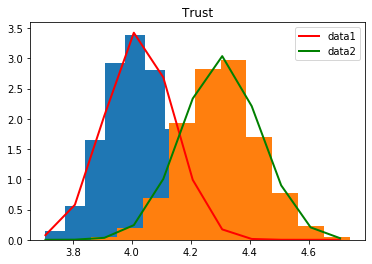

overlap is:  0.2461
p-value is:  0.017


In [16]:
summary_data = pd.DataFrame(columns=['percentage', 'model_score', 
                                     'mean_effect_share', 'mean_effect_trust', 
                                     'overlap_share','p_value_share', 
                                     'overlap_trust','p_value_trust'])

for i, curr_file in enumerate(missing_data_files): #['drive/My Drive/Lutzke_2019/Data_GEC_clean_python_friendly.csv']
    ## load in data  
    print("Analyzing file: ", curr_file)
    data_clean = pd.read_csv(curr_file)
    pct = int(curr_file[-6:-4]) # 0

    if 'Unnamed: 0' in data_clean.columns:
        data_clean = data_clean.drop(columns=['Unnamed: 0'])

    covariate_names = ["believe_climate_change_q",\
                        "believer_doubter",\
                        "burning_oil_co2",\
                        "nuclear_power_co2",\
                        "co2_methane",\
                        "global_co2_increase",\
                        "climate_change_human_activities",\
                        "last_century_global_increase",\
                        "today_concentration_already_occured",\
                        'scientists_expect_warming_increase_melting',\
                        'scientists_expect_increase_extreme_events',\
                        'scientists_expect_increase_water_evap',\
                        'scientists_expect_climate_change_evenly',\
                        'feelings_toward_fb',\
                        'gender', 'age', 'education',\
                        'politics', 'conservative']

    result_names = ['post_trust','post_type', 'condition','share_post']

    input_data = data_clean.loc[(data_clean.condition=='Enhanced Guidelines')|
                                (data_clean.condition=='Control'), 
                                covariate_names+result_names]
    ## fill in NA as "missing"
    new_col = ["missing_"+col for col in covariate_names]
    values = dict(zip(covariate_names,new_col))
    #values = "missing"
    input_data = input_data.fillna(value=values)

    ## one hot encoding
    numeric_cols = find_numeric_col(input_data)
    need_factorize_cols = list(set(covariate_names)-set(numeric_cols))
    input_data_fact = add_dummy(input_data, need_factorize_cols)
    #input_data_fact.to_csv("drive/My Drive/Lutzke_2019/MAR_data.csv", index=False)
    
    input_data_fact['isTreat'] = 0
    input_data_fact.loc[input_data_fact.condition=='Enhanced Guidelines','isTreat'] = 1

    display(input_data_fact.head(2))

    ## propensity score and matching
    model_score, stratas_data = propensity_score(input_data_fact, treat_col='isTreat')
    print(stratas_data.groupby(by=['isTreat','groups']).agg({"Correct":"count"}))

    match_by_groups = matching_groups(stratas_data)

    ## result
    df = match_by_groups
    mean_effect_share, mean_effect_trust, overlap_s, p_value_s, overlap_t, p_value_t = result_generation(df)

    summary_data.loc[i,:] = [pct, model_score, mean_effect_share, 
                           mean_effect_trust, overlap_s, p_value_s, 
                           overlap_t, p_value_t]

STEP 2: propensity score

In [0]:
stratas_data = propensity_score(input_data_fact, treat_col='isTreat')
print(stratas_data.groupby(by=['isTreat','groups']).agg({"Correct":"count"}))

match_by_groups = matching_groups(stratas_data)

Model score: 0.6421167484997272
                Correct
isTreat groups         
0       0            24
        1           333
        2           467
        3           107
        4             3
1       0             3
        1           140
        2           468
        3           270
        4            18


In [0]:
# from pymatch.Matcher import Matcher
# test = input_data_fact[input_data_fact.isTreat == 1][input_data_fact.columns.difference(result_names)].reset_index(drop=True)
# control = input_data_fact[input_data_fact.isTreat == 0][input_data_fact.columns.difference(result_names)].reset_index(drop=True)
# ## initalize match model
# m = Matcher(test, control, yvar="isTreat", exclude=[])
# np.random.seed(2019)

# m.fit_scores(balance=True, nmodels=10)

STEP 3: result



 Share =================

Mean effect:  -0.6975772765246409
  post_type            condition  count      mean  ...   25%   50%   75%   max
0      Fake              Control  441.0  4.473016  ...  1.10  3.80  6.40  11.0
1      Fake  Enhanced Guidelines  456.0  3.775439  ...  1.00  2.75  6.00  11.0
2      Real              Control  458.0  5.562445  ...  2.60  6.00  8.10  11.0
3      Real  Enhanced Guidelines  443.0  5.647178  ...  2.85  6.00  8.25  11.0

[4 rows x 10 columns]





 Trust =================

Mean effect:  -0.3333199069101287
  post_type            condition  count      mean  ...   25%    50%   75%   max
0      Fake              Control  441.0  4.362925  ...  2.05  4.050  6.40  10.0
1      Fake  Enhanced Guidelines  456.0  4.029605  ...  1.85  3.775  5.80  10.0
2      Real              Control  458.0  6.208624  ...  4.85  6.450  8.15  10.0
3      Real  Enhanced Guidelines  443.0  6.604853  ...  5.10  6.850  8.25  10.0

[4 rows x 10 columns]





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


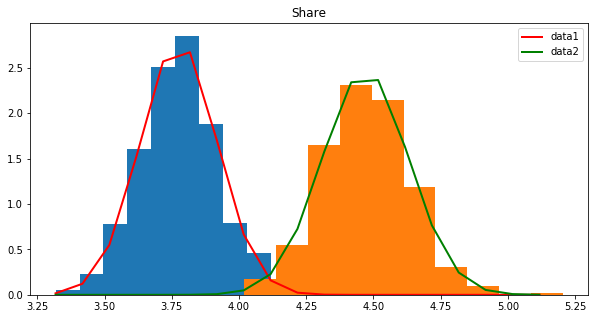

overlap is:  0.024
p-value is:  0.0


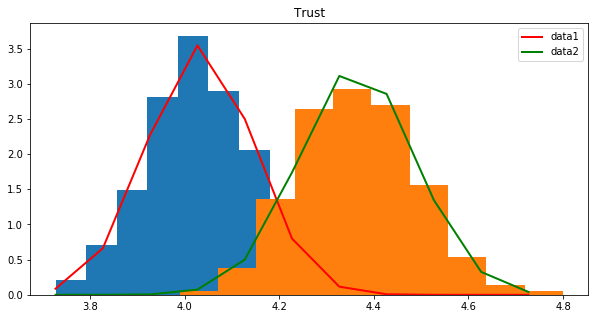

overlap is:  0.15
p-value is:  0.001


In [0]:
df = match_by_groups
result_generation(df)

## Plot

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [0]:
summary_data = pd.read_csv('drive/My Drive/Lutzke_2019/result_summary/MCAR_under_propensity.csv')
summary_data.head()

,percentage,model_score,mean_effect_share,mean_effect_trust,overlap_share,p_value_share,overlap_trust,p_value_trust,p_v_s_significant,p_v_t_significant
0,10,0.647027,-0.467653,-0.181285,0.1092,0.002,0.4374,0.066,1,0
1,20,0.645936,-0.533267,-0.228542,0.0829,0.001,0.3545,0.034,1,1
2,30,0.637207,-0.514833,-0.147657,0.0885,0.000,0.5324,0.105,1,0
3,40,0.636116,-0.581901,-0.320165,0.0564,0.000,0.1988,0.004,1,1
4,50,0.636116,-0.511256,-0.282765,0.0782,0.000,0.2300,0.010,1,1


In [0]:
summary_data = summary_data.sort_values(by=['percentage']).reset_index(drop=True)
summary_data

,percentage,model_score,mean_effect_share,mean_effect_trust,overlap_share,p_value_share,overlap_trust,p_value_trust
0,10,0.702036,-0.465132,-0.187939,0.1032,0.001,0.4083,0.056
1,20,0.696677,-0.594518,-0.219737,0.0367,0,0.308,0.026
2,30,0.690247,-0.732018,-0.373465,0.0139,0,0.1192,0
3,40,0.678457,-0.283991,-0.155702,0.3066,0.029,0.5533,0.133
4,50,0.679528,-0.751316,-0.130373,0.0106,0,0.5846,0.141
5,60,0.65702,-0.473154,-0.108501,0.1024,0,0.6216,0.17


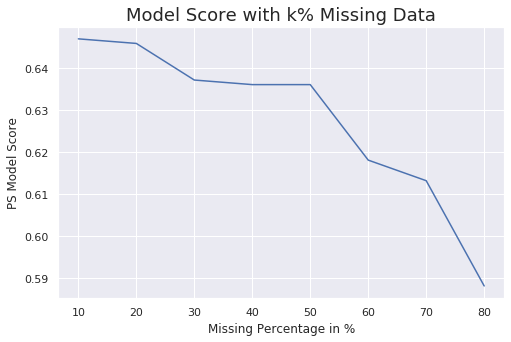

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set()
plt.plot(summary_data.percentage, summary_data.model_score)
plt.xlabel("Missing Percentage in %")
plt.ylabel("PS Model Score")
plt.title("Model Score with k% Missing Data", fontsize=18)
plt.show()

In [0]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the mean on top
    plt.plot(mean, color_mean)
    # plot the shaded range of the confidence intervals
    plt.fill_between(mean, ub, lb,color=color_shading, alpha=.5)
    

In [0]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    a = a[:-3]
    return r'${} \times 10^{{{}}}$'.format(a, b)


In [0]:
summary_data['p_v_s_significant'] = summary_data.p_value_share<0.05 
summary_data['p_v_s_significant'] =summary_data['p_v_s_significant'].astype(int)
summary_data['p_v_t_significant'] = summary_data.p_value_trust<0.05 
summary_data['p_v_t_significant'] = summary_data['p_v_t_significant'].astype(int)
summary_data

,percentage,model_score,mean_effect_share,mean_effect_trust,overlap_share,p_value_share,overlap_trust,p_value_trust,p_v_s_significant,p_v_t_significant
0,10,0.702036,-0.465132,-0.187939,0.1032,0.001,0.4083,0.056,1,0
1,20,0.696677,-0.594518,-0.219737,0.0367,0,0.308,0.026,1,1
2,30,0.690247,-0.732018,-0.373465,0.0139,0,0.1192,0,1,1
3,40,0.678457,-0.283991,-0.155702,0.3066,0.029,0.5533,0.133,1,0
4,50,0.679528,-0.751316,-0.130373,0.0106,0,0.5846,0.141,1,0
5,60,0.65702,-0.473154,-0.108501,0.1024,0,0.6216,0.17,1,0


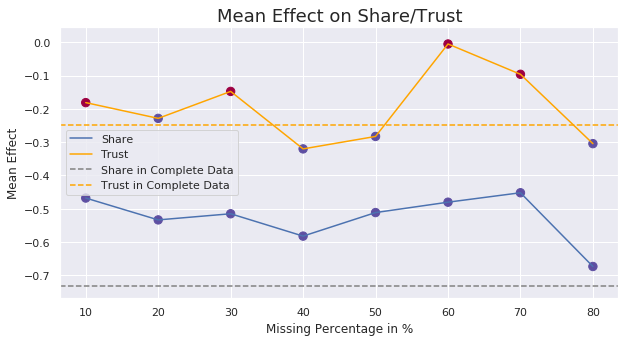

In [0]:

fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sc = plt.scatter([summary_data.percentage,summary_data.percentage], 
                 [summary_data.mean_effect_share,summary_data.mean_effect_trust], s=[70,70], 
                 c=[summary_data.p_v_s_significant,summary_data.p_v_t_significant], cmap="Spectral")
plt.plot(summary_data.percentage, summary_data.mean_effect_share, c="b", label="Share")

plt.plot(summary_data.percentage, summary_data.mean_effect_trust, c="orange", label="Trust")
plt.axhline(y=3.775439 - 4.506918, 
            ls="--", color="grey", label="Share in Complete Data")
plt.axhline(y=4.029605- 4.276625, 
            ls="--", color="orange", label="Trust in Complete Data")
plt.xlabel("Missing Percentage in %")
plt.ylabel("Mean Effect")
plt.legend()
plt.title("Mean Effect on Share/Trust", fontsize=18)
plt.show()

In [0]:
summary_data.to_csv('drive/My Drive/Lutzke_2019/MNAR_v2_under_propensity.csv', index=False)